# TopicWeave: Domain-Adapted Integration
This notebook integrates domain-adapted SciBERT embeddings with SPECTER embeddings
to create a domain-adapted version of TopicWeave.

## Setup

In [ ]:
# Install required packages
!pip install -q numpy pandas matplotlib scikit-learn tqdm seaborn

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import json
from datetime import datetime

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define directories
PROJECT_DIR = '/content/drive/MyDrive/MIDS/W266/final_project/'
DOMAIN_DIR = f"{PROJECT_DIR}/domain_adaptation/"
EMBEDDING_DIR = f"{PROJECT_DIR}/embeddings/"
OUTPUT_DIR = f"{PROJECT_DIR}/domain_integration/"
FIGURE_DIR = f"{PROJECT_DIR}/figures/domain_integration/"

In [ ]:
# Create directories
for directory in [OUTPUT_DIR, FIGURE_DIR]:
    os.makedirs(directory, exist_ok=True)

print("TopicWeave Domain-Adapted Integration - Started at", datetime.now().strftime('%Y-%m-%d %H:%M'))

TopicWeave Domain-Adapted Integration - Started at 2025-03-29 22:30


## Load embedddings and document data

In [ ]:
def load_embeddings_and_data():
    """
    Load all required embeddings and document data
    """
    print("\n===== Loading Embeddings and Document Data =====")

    # Load document info
    docs_df = pd.read_csv(f"{EMBEDDING_DIR}/document_info.csv")
    print(f"Loaded {len(docs_df)} documents")

    # Load domain-adapted SciBERT embeddings
    domain_scibert_path = f"{DOMAIN_DIR}/domain_adapted_embeddings.npy"
    if os.path.exists(domain_scibert_path):
        domain_scibert_embeddings = np.load(domain_scibert_path)
        print(f"Loaded domain-adapted SciBERT embeddings: {domain_scibert_embeddings.shape}")
    else:
        raise FileNotFoundError(f"Domain-adapted embeddings not found at {domain_scibert_path}")

    # Load original SPECTER embeddings
    specter_path = f"{EMBEDDING_DIR}/citation_embeddings.npy"
    if os.path.exists(specter_path):
        specter_embeddings = np.load(specter_path)
        print(f"Loaded SPECTER embeddings: {specter_embeddings.shape}")
    else:
        raise FileNotFoundError(f"SPECTER embeddings not found at {specter_path}")

    # Load metadata
    with open(f"{EMBEDDING_DIR}/embeddings_metadata.json", "r") as f:
        metadata = json.load(f)

    # Return all loaded data
    return {
        "docs_df": docs_df,
        "domain_scibert_embeddings": domain_scibert_embeddings,
        "specter_embeddings": specter_embeddings,
        "metadata": metadata
    }

## Optimize weights for combining embeddings

In [ ]:
def combine_embeddings(scibert_embeddings, specter_embeddings, weight_scibert=0.5):
    """
    Combine embeddings with specified weights

    Args:
        scibert_embeddings: SciBERT embeddings
        specter_embeddings: SPECTER embeddings
        weight_scibert: Weight for SciBERT embeddings (1-weight for SPECTER)

    Returns:
        Combined embeddings
    """
    assert scibert_embeddings.shape[0] == specter_embeddings.shape[0], "Number of embeddings must match"

    # Weighted combination
    combined = (weight_scibert * scibert_embeddings) + ((1 - weight_scibert) * specter_embeddings)

    # Normalize combined embeddings
    norm = np.linalg.norm(combined, axis=1, keepdims=True)
    combined_norm = combined / norm

    return combined_norm

In [ ]:
def optimize_weights(scibert_embeddings, specter_embeddings, categories, weight_range=None):
    """
    Find the optimal weight combination for SciBERT and SPECTER embeddings

    Args:
        scibert_embeddings: SciBERT embeddings
        specter_embeddings: SPECTER embeddings
        categories: Document categories (for evaluating alignment)
        weight_range: List of weights to try

    Returns:
        Dictionary with optimal weight and scores
    """
    if weight_range is None:
        weight_range = np.linspace(0.0, 1.0, 11)  # [0.0, 0.1, 0.2, ..., 1.0]

    print("\n===== Optimizing Weights for Embedding Combination =====")
    results = []

    # Convert categories to numeric labels
    encoder = LabelEncoder()
    category_labels = encoder.fit_transform(categories)

    # Number of clusters equals number of categories
    n_clusters = len(set(categories))

    for weight in tqdm(weight_range, desc="Testing weights"):
        # Combine embeddings with this weight
        combined = combine_embeddings(scibert_embeddings, specter_embeddings, weight_scibert=weight)

        # Calculate silhouette score
        sil_score = silhouette_score(
            combined,
            category_labels,
            sample_size=min(5000, len(categories)),
            metric='cosine'
        )

        # Perform K-means clustering and evaluate against true categories
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(combined)

        # Calculate metrics
        ari = adjusted_rand_score(category_labels, cluster_labels)
        nmi = normalized_mutual_info_score(category_labels, cluster_labels)

        # Calculate within-category similarity
        sample_size = min(1000, len(categories))
        indices = np.random.choice(len(categories), sample_size, replace=False)

        sampled_embeddings = combined[indices]
        sampled_categories = [categories[i] for i in indices]

        # Calculate within-category similarity
        similarities = []
        for cat in set(sampled_categories):
            cat_indices = [i for i, c in enumerate(sampled_categories) if c == cat]
            if len(cat_indices) > 1:
                cat_embeddings = sampled_embeddings[cat_indices]
                sim_matrix = cosine_similarity(cat_embeddings)
                np.fill_diagonal(sim_matrix, 0)
                avg_sim = sim_matrix.sum() / (len(cat_indices) * (len(cat_indices) - 1))
                similarities.append(avg_sim)

        within_cat_similarity = np.mean(similarities) if similarities else 0

        # Calculate combined score
        combined_score = 0.3 * sil_score + 0.3 * nmi + 0.2 * ari + 0.2 * within_cat_similarity

        # Store results
        results.append({
            'weight_scibert': weight,
            'silhouette_score': sil_score,
            'ari': ari,
            'nmi': nmi,
            'within_category_similarity': within_cat_similarity,
            'combined_score': combined_score
        })

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Find optimal weight
    best_idx = results_df['combined_score'].idxmax()
    optimal_weight = results_df.loc[best_idx, 'weight_scibert']

    # Plot results
    plt.figure(figsize=(12, 8))
    plt.plot(results_df['weight_scibert'], results_df['silhouette_score'], 'b-o', label='Silhouette Score')
    plt.plot(results_df['weight_scibert'], results_df['nmi'], 'g-o', label='NMI')
    plt.plot(results_df['weight_scibert'], results_df['ari'], 'r-o', label='ARI')
    plt.plot(results_df['weight_scibert'], results_df['within_category_similarity'], 'c-o', label='Within-Category Similarity')
    plt.plot(results_df['weight_scibert'], results_df['combined_score'], 'k-o', label='Combined Score')
    plt.axvline(x=optimal_weight, color='black', linestyle='--', label=f'Optimal Weight: {optimal_weight:.2f}')
    plt.xlabel('SciBERT Weight')
    plt.ylabel('Score')
    plt.title('Weight Optimization Results (Domain-Adapted)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{FIGURE_DIR}/domain_weight_optimization.png", dpi=300)

    print(f"Optimal domain-adapted SciBERT weight: {optimal_weight:.2f}")
    print(f"Optimal SPECTER weight: {1-optimal_weight:.2f}")

    return {
        'optimal_weight_scibert': optimal_weight,
        'optimal_weight_specter': 1 - optimal_weight,
        'results': results_df
    }

## Create integrated embeddings

In [ ]:
def create_domain_topicweave_embeddings(data, weight_results=None):
    """
    Create domain-adapted TopicWeave embeddings

    Args:
        data: Dictionary with loaded data
        weight_results: Optional weight optimization results

    Returns:
        Domain-adapted TopicWeave embeddings
    """
    print("\n===== Creating Domain-Adapted TopicWeave Embeddings =====")

    # Extract embeddings
    domain_scibert_embeddings = data["domain_scibert_embeddings"]
    specter_embeddings = data["specter_embeddings"]

    # Use optimal weight if weight_results is provided, otherwise use default 0.5
    if weight_results is not None:
        weight_scibert = weight_results["optimal_weight_scibert"]
    else:
        weight_scibert = 0.5
        print("No weight optimization results provided. Using default weight: 0.5")

    # Combine embeddings
    domain_topicweave_embeddings = combine_embeddings(
        scibert_embeddings=domain_scibert_embeddings,
        specter_embeddings=specter_embeddings,
        weight_scibert=weight_scibert
    )

    print(f"Created domain-adapted TopicWeave embeddings: {domain_topicweave_embeddings.shape}")
    return domain_topicweave_embeddings

## Save embeddings and results

In [ ]:
def save_embeddings_and_metadata(domain_topicweave_embeddings, weight_results, data):
    """
    Save the domain-adapted TopicWeave embeddings and metadata

    Args:
        domain_topicweave_embeddings: Domain-adapted TopicWeave embeddings
        weight_results: Weight optimization results
        data: Dictionary with loaded data
    """
    print("\n===== Saving Embeddings and Metadata =====")

    # Save domain-adapted TopicWeave embeddings
    np.save(f"{OUTPUT_DIR}/domain_topicweave_embeddings.npy", domain_topicweave_embeddings)

    # Save weight optimization results
    weight_results["results"].to_csv(f"{OUTPUT_DIR}/domain_weight_optimization_results.csv", index=False)

    # Save metadata
    metadata = data["metadata"].copy()
    metadata.update({
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "domain_scibert_weight": float(weight_results["optimal_weight_scibert"]),
        "specter_weight": float(weight_results["optimal_weight_specter"]),
        "embedding_dimension": int(domain_topicweave_embeddings.shape[1])
    })

    with open(f"{OUTPUT_DIR}/domain_topicweave_metadata.json", "w") as f:
        json.dump(metadata, f, indent=2)

    print(f"Domain-adapted TopicWeave embeddings saved to {OUTPUT_DIR}/domain_topicweave_embeddings.npy")
    print(f"Metadata saved to {OUTPUT_DIR}/domain_topicweave_metadata.json")

## Main execution

In [ ]:
# 1. Load embeddings and document data
data = load_embeddings_and_data()


===== Loading Embeddings and Document Data =====
Loaded 45655 documents
Loaded domain-adapted SciBERT embeddings: (45655, 768)
Loaded SPECTER embeddings: (45655, 768)



===== Optimizing Weights for Embedding Combination =====


Testing weights: 100%|██████████| 11/11 [02:10<00:00, 11.86s/it]


Optimal domain-adapted SciBERT weight: 0.60
Optimal SPECTER weight: 0.40


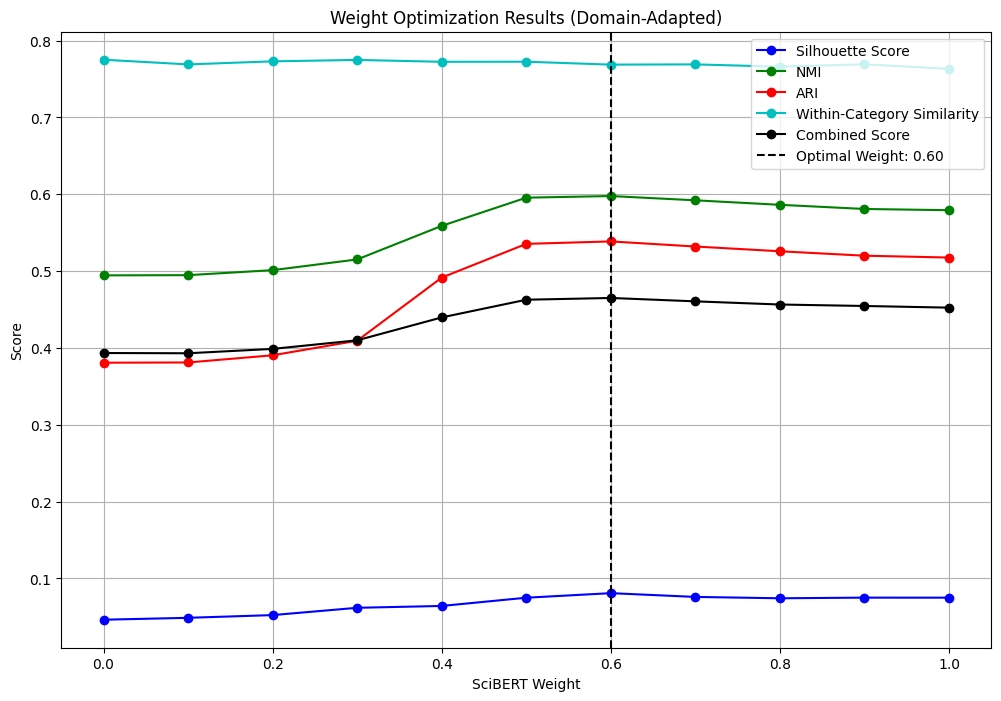

In [ ]:
# 2. Optimize weights
weight_results = optimize_weights(
    scibert_embeddings=data["domain_scibert_embeddings"],
    specter_embeddings=data["specter_embeddings"],
    categories=data["docs_df"]["category"].tolist()
)

In [ ]:
# 3. Create domain-adapted TopicWeave embeddings
domain_topicweave_embeddings = create_domain_topicweave_embeddings(
    data=data,
    weight_results=weight_results
)


===== Creating Domain-Adapted TopicWeave Embeddings =====
Created domain-adapted TopicWeave embeddings: (45655, 768)


In [ ]:
# 4. Save embeddings and metadata
save_embeddings_and_metadata(
    domain_topicweave_embeddings=domain_topicweave_embeddings,
    weight_results=weight_results,
    data=data
)

print("\n===== Domain-Adapted TopicWeave Integration Complete =====")
print(f"Completed at {datetime.now().strftime('%Y-%m-%d %H:%M')}")


===== Saving Embeddings and Metadata =====
Domain-adapted TopicWeave embeddings saved to /content/drive/MyDrive/MIDS/W266/final_project//domain_integration//domain_topicweave_embeddings.npy
Metadata saved to /content/drive/MyDrive/MIDS/W266/final_project//domain_integration//domain_topicweave_metadata.json

===== Domain-Adapted TopicWeave Integration Complete =====
Completed at 2025-03-29 22:33
